# Data Preparation and Exploratory Data Analysis

## Objective
Load, clean, and explore the Open University Learning Analytics datasets. Prepare features for predictive and clustering models through comprehensive feature engineering.

## CRISP-DM Stage
Business Understanding, Data Understanding, and Data Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load Datasets

Load all seven CSV files from the data directory and display basic information about each dataset.

In [6]:
data_path = '../0_Data/'

print('Loading datasets...')
courses = pd.read_csv(f'{data_path}1_courses.csv')
assessments = pd.read_csv(f'{data_path}2_assessments.csv')
vle = pd.read_csv(f'{data_path}3_vle.csv')
student_info = pd.read_csv(f'{data_path}4_studentInfo.csv')
student_registration = pd.read_csv(f'{data_path}5_studentRegistration.csv')
student_assessment = pd.read_csv(f'{data_path}6_studentAssessment.csv')
student_vle = pd.read_csv(f'{data_path}7_studentVle.csv')

print('All datasets loaded successfully\n')

datasets = {
    'courses': courses,
    'assessments': assessments,
    'vle': vle,
    'student_info': student_info,
    'student_registration': student_registration,
    'student_assessment': student_assessment,
    'student_vle': student_vle
}

print('Dataset Shapes and Overview:')
print('=' * 80)
for name, df in datasets.items():
    print(f'\n{name.upper()}: {df.shape}')
    print(f'Columns: {list(df.columns)}')

Loading datasets...
All datasets loaded successfully

Dataset Shapes and Overview:

COURSES: (22, 3)
Columns: ['code_module', 'code_presentation', 'module_presentation_length']

ASSESSMENTS: (206, 6)
Columns: ['code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'weight']

VLE: (6364, 6)
Columns: ['id_site', 'code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to']

STUDENT_INFO: (32593, 12)
Columns: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result']

STUDENT_REGISTRATION: (32593, 5)
Columns: ['code_module', 'code_presentation', 'id_student', 'date_registration', 'date_unregistration']

STUDENT_ASSESSMENT: (173912, 5)
Columns: ['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score']

STUDENT_VLE: (10655280, 6)
Columns: ['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 's

## Section 2: Exploratory Data Analysis

Analyse missing values, distributions, and key statistics in the student datasets.


EXPLORATORY DATA ANALYSIS

Missing Values Analysis:
--------------------------------------------------------------------------------

STUDENT_INFO:
imd_band    3.41
dtype: float64

STUDENT_ASSESSMENT:
score    0.1
dtype: float64

STUDENT_VLE:
  No missing values


STUDENT_INFO SUMMARY:
--------------------------------------------------------------------------------
Total records: 32593

Final Result Distribution:
final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64


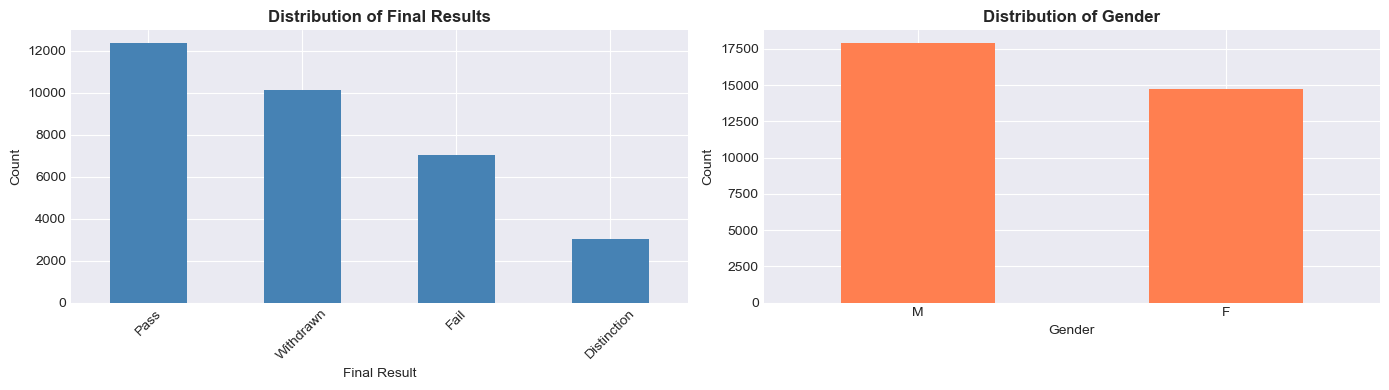


Age Band Distribution:
age_band
0-35     22944
35-55     9433
55<=       216
Name: count, dtype: int64

Statistical Summary:
       studied_credits  num_of_prev_attempts
count     32593.000000          32593.000000
mean         79.758691              0.163225
std          41.071900              0.479758
min          30.000000              0.000000
25%          60.000000              0.000000
50%          60.000000              0.000000
75%         120.000000              0.000000
max         655.000000              6.000000


In [7]:
print('\n' + '=' * 80)
print('EXPLORATORY DATA ANALYSIS')
print('=' * 80)

# Missing values analysis
print('\nMissing Values Analysis:')
print('-' * 80)
for name, df in [('student_info', student_info), 
                  ('student_assessment', student_assessment),
                  ('student_vle', student_vle)]:
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    print(f'\n{name.upper()}:')
    if missing_pct[missing_pct > 0].empty:
        print('  No missing values')
    else:
        print(missing_pct[missing_pct > 0])

# Student info analysis
print('\n\nSTUDENT_INFO SUMMARY:')
print('-' * 80)
print(f'Total records: {len(student_info)}')
print('\nFinal Result Distribution:')
print(student_info['final_result'].value_counts())

# Visualise distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

student_info['final_result'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Final Results', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Final Result')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

student_info['gender'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Distribution of Gender', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print('\nAge Band Distribution:')
print(student_info['age_band'].value_counts())

print('\nStatistical Summary:')
print(student_info[['studied_credits', 'num_of_prev_attempts']].describe())

## Section 2b: Clustering Feature Engineering

Compute behavioral features specifically for the unsupervised clustering model:
- **Intensity**: Total engagement volume (clicks).
- **Regularity**: Consistency of engagement (standard deviation of login intervals).
- **Procrastination**: Submission behavior (average delay relative to due date).
- **Breadth**: Exploration scope (unique materials accessed).

*Note: These features are saved separately to `clustering_features.pkl` and are not used in the classification pipeline to maintain orthogonality.*

In [ ]:
print('\n' + '=' * 80)
print('SECTION 2b: CLUSTERING FEATURE ENGINEERING')
print('=' * 80)

# Define keys for student-presentation granularity
keys = ['id_student', 'code_module', 'code_presentation']

# ----------------------------------------------------------------------------
# 1. Intensity (Total Clicks)
# ----------------------------------------------------------------------------
# Sum of all clicks per student per presentation
intensity = student_vle.groupby(keys)['sum_click'].sum().rename('Intensity')

# ----------------------------------------------------------------------------
# 2. Regularity (Std Dev of Study Interval)
# ----------------------------------------------------------------------------
# Calculate the standard deviation of the time difference between login dates
# Lower std dev = More Regular (Consistent study habits)
print("Calculating Regularity (this may take a moment)...")
svle_sorted = student_vle.sort_values(keys + ['date'])
svle_sorted['date_diff'] = svle_sorted.groupby(keys)['date'].diff()
regularity = svle_sorted.groupby(keys)['date_diff'].std().rename('Regularity')

# ----------------------------------------------------------------------------
# 3. Procrastination (Average Submission Delay)
# ----------------------------------------------------------------------------
# Delay = Date Submitted - Due Date. Positive = Late.
# Ensure numeric types for calculation
student_assessment['date_submitted'] = pd.to_numeric(student_assessment['date_submitted'], errors='coerce')
assessments['date'] = pd.to_numeric(assessments['date'], errors='coerce')

# Merge to get due dates and module info
sa_merged = student_assessment.merge(
    assessments[['id_assessment', 'code_module', 'code_presentation', 'date']], 
    on='id_assessment', 
    how='left'
)

# Calculate delay
sa_merged['delay'] = sa_merged['date_submitted'] - sa_merged['date']

# Average delay per student
procrastination = sa_merged.groupby(keys)['delay'].mean().rename('Procrastination')

# ----------------------------------------------------------------------------
# 4. Breadth (Resource Variety)
# ----------------------------------------------------------------------------
# Number of unique sites (materials) visited
breadth = student_vle.groupby(keys)['id_site'].nunique().rename('Breadth')

# ----------------------------------------------------------------------------
# Combine and Save
# ----------------------------------------------------------------------------
clustering_features = pd.concat([intensity, regularity, procrastination, breadth], axis=1)

# Handle Missing Values
clustering_features['Intensity'] = clustering_features['Intensity'].fillna(0)
clustering_features['Breadth'] = clustering_features['Breadth'].fillna(0)
clustering_features['Regularity'] = clustering_features['Regularity'].fillna(0)
clustering_features['Procrastination'] = clustering_features['Procrastination'].fillna(0)

# Display stats
print(f'\nClustering Features Created. Shape: {clustering_features.shape}')
print(clustering_features.describe().round(2))

# Save
output_path = '../2_Outputs/clustering_features.pkl'
# Ensure directory exists (it should, but safe to check)
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

clustering_features.to_pickle(output_path)
print(f'\n✓ Clustering features saved to: {output_path}')

## Section 3: VLE Feature Engineering

Aggregate Virtual Learning Environment data to create engagement metrics at the student level.

In [8]:
print('\n' + '=' * 80)
print('VLE FEATURE ENGINEERING')
print('=' * 80)

student_vle['date'] = pd.to_numeric(student_vle['date'], errors='coerce')
course_lengths = courses[['code_module', 'code_presentation', 'module_presentation_length']]
course_lengths.columns = ['code_module', 'code_presentation', 'course_end_date']

student_vle_merged = student_vle.merge(
    course_lengths, 
    on=['code_module', 'code_presentation'], 
    how='left'
)

vle_agg = student_vle_merged.groupby(['id_student', 'code_module', 'code_presentation']).agg({
    'sum_click': ['sum', 'mean', 'std', 'max'],
    'date': ['min', 'max', 'count']
}).fillna(0).astype(np.int32)

vle_agg.columns = ['_'.join(col).strip() for col in vle_agg.columns.values]
vle_agg = vle_agg.reset_index()

# Calculate late clicks
vle_late = student_vle_merged[student_vle_merged['date'] > student_vle_merged['course_end_date']].groupby(
    ['id_student', 'code_module', 'code_presentation']
)['sum_click'].sum().reset_index()
vle_late.columns = ['id_student', 'code_module', 'code_presentation', 'late_clicks']

vle_agg = vle_agg.merge(vle_late, on=['id_student', 'code_module', 'code_presentation'], how='left')
vle_agg['late_clicks'] = vle_agg['late_clicks'].fillna(0).astype(np.int32)

vle_agg['course_weeks'] = (vle_agg['date_max'] - vle_agg['date_min']) / 7.0 + 1
vle_agg['avg_clicks_per_week'] = (vle_agg['sum_click_sum'] / vle_agg['course_weeks']).fillna(0).astype(np.float32)
vle_agg = vle_agg.fillna(0)

vle_agg.columns = vle_agg.columns.str.replace('sum_click_sum', 'total_clicks')
vle_agg.columns = vle_agg.columns.str.replace('sum_click_mean', 'avg_clicks_per_day')
vle_agg.columns = vle_agg.columns.str.replace('sum_click_std', 'std_clicks')
vle_agg.columns = vle_agg.columns.str.replace('sum_click_max', 'max_clicks_per_day')
vle_agg.columns = vle_agg.columns.str.replace('date_count', 'days_active')

print(f'VLE Aggregated Features Shape: {vle_agg.shape}')
print(f'\nFeatures Created: {vle_agg.columns.tolist()}')


VLE FEATURE ENGINEERING
VLE Aggregated Features Shape: (29228, 13)

Features Created: ['id_student', 'code_module', 'code_presentation', 'total_clicks', 'avg_clicks_per_day', 'std_clicks', 'max_clicks_per_day', 'date_min', 'date_max', 'days_active', 'late_clicks', 'course_weeks', 'avg_clicks_per_week']


## Section 4: Assessment Feature Engineering

Create assessment-level features including weighted scores and submission delays.

In [9]:
print('\n' + '=' * 80)
print('ASSESSMENT FEATURE ENGINEERING')
print('=' * 80)

student_assessment['date_submitted'] = pd.to_numeric(student_assessment['date_submitted'], errors='coerce')
assessments['date'] = pd.to_numeric(assessments['date'], errors='coerce')
student_assessment['score'] = pd.to_numeric(student_assessment['score'], errors='coerce')

assessment_merged = student_assessment.merge(
    assessments[['id_assessment', 'weight', 'code_module', 'code_presentation', 'date']],
    on=['id_assessment'],
    how='left'
)

assessment_merged['submission_delay'] = assessment_merged['date_submitted'] - assessment_merged['date']
assessment_merged['submission_delay'] = assessment_merged['submission_delay'].fillna(0).astype(np.int32)
assessment_merged['is_late'] = (assessment_merged['submission_delay'] > 0).astype(int)
assessment_merged['weighted_score'] = (assessment_merged['score'] * assessment_merged['weight'] / 100).fillna(0)

assessment_agg = assessment_merged.groupby(['id_student', 'code_module', 'code_presentation']).agg({
    'score': ['mean', 'std', 'min', 'max'],
    'weighted_score': 'sum',
    'submission_delay': ['mean', 'std'],
    'is_late': 'sum',
    'id_assessment': 'count'
}).fillna(0).astype(np.float32)

assessment_agg.columns = ['_'.join(col).strip() for col in assessment_agg.columns.values]
assessment_agg = assessment_agg.reset_index()

assessment_agg.columns = assessment_agg.columns.str.replace('weighted_score_sum', 'weighted_avg_score')
assessment_agg.columns = assessment_agg.columns.str.replace('submission_delay_', 'submit_delay_')
assessment_agg.columns = assessment_agg.columns.str.replace('is_late_sum', 'num_late_submissions')
assessment_agg.columns = assessment_agg.columns.str.replace('id_assessment_count', 'num_assessments')

assessment_agg = assessment_agg.fillna(0)
assessment_agg['target_score'] = assessment_agg['weighted_avg_score'].clip(0, 100).astype(np.float32)

print(f'Assessment Aggregated Features Shape: {assessment_agg.shape}')
print(f'\nTarget Variable Statistics:')
print(assessment_agg['target_score'].describe())


ASSESSMENT FEATURE ENGINEERING
Assessment Aggregated Features Shape: (25843, 13)

Target Variable Statistics:
count    25843.000000
mean        54.335770
std         36.016392
min          0.000000
25%         16.134999
50%         63.540001
75%         86.000000
max        100.000000
Name: target_score, dtype: float64


## Section 5: Data Merging and Integration

Merge all engineered features with student demographics using composite keys.

In [10]:
print('\n' + '=' * 80)
print('DATA MERGING AND INTEGRATION')
print('=' * 80)

df_merged = student_info.merge(
    vle_agg,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)

print(f'After merging with VLE: {df_merged.shape}')

df_merged = df_merged.merge(
    assessment_agg,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)

print(f'After merging with Assessments: {df_merged.shape}')

registration_features = student_registration[['id_student', 'code_module', 'code_presentation', 'date_registration']].copy()
registration_features['date_registration'] = pd.to_numeric(registration_features['date_registration'], errors='coerce')

df_merged = df_merged.merge(
    registration_features,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)

print(f'After merging with Registration: {df_merged.shape}')


DATA MERGING AND INTEGRATION
After merging with VLE: (32593, 22)
After merging with Assessments: (32593, 32)
After merging with Registration: (32593, 33)


## Section 6: Missing Values and Data Cleaning

Handle missing values and optimise data types for memory efficiency.

In [11]:
print('\n' + '=' * 80)
print('HANDLING MISSING VALUES AND DATA CLEANING')
print('=' * 80)

missing_pct = (df_merged.isnull().sum() / len(df_merged) * 100).round(2)
print('\nMissing Values:')
print(missing_pct[missing_pct > 0])

cols_to_drop = missing_pct[missing_pct > 90].index.tolist()
if cols_to_drop:
    print(f'\nDropping columns with >90% missing: {cols_to_drop}')
    df_merged = df_merged.drop(columns=cols_to_drop)

behavioral_cols = [
    'total_clicks', 'avg_clicks_per_day', 'std_clicks', 'max_clicks_per_day',
    'days_active', 'late_clicks', 'avg_clicks_per_week', 'course_weeks'
]
for col in behavioral_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(0)

assessment_cols = [col for col in df_merged.columns if 'score_' in col or 'submit_delay_' in col or 'num_' in col]
for col in assessment_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(0)

if 'date_registration' in df_merged.columns:
    df_merged['date_registration'] = df_merged['date_registration'].fillna(df_merged['date_registration'].mean())

print(f'\nRows before filtering: {len(df_merged)}')
# Keep all students with valid final_result (including Withdrawn)
df_merged = df_merged[df_merged['final_result'].notna()]
print(f'Rows after filtering by final_result: {len(df_merged)}')
# Impute missing target_score to 0 for students with no assessment attempts
df_merged['target_score'] = df_merged['target_score'].fillna(0)

numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col in ['id_student']:
        continue
    elif df_merged[col].dtype == np.float64:
        df_merged[col] = df_merged[col].astype(np.float32)
    elif df_merged[col].dtype == np.int64:
        if df_merged[col].max() < 2147483647:
            df_merged[col] = df_merged[col].astype(np.int32)

print(f'\nFinal Dataset Shape: {df_merged.shape}')
print(f'Memory Usage: {df_merged.memory_usage(deep=True).sum() / 1024**2:.2f} MB')


HANDLING MISSING VALUES AND DATA CLEANING



Missing Values:
imd_band                 3.41
total_clicks            10.32
avg_clicks_per_day      10.32
std_clicks              10.32
max_clicks_per_day      10.32
date_min                10.32
date_max                10.32
days_active             10.32
late_clicks             10.32
course_weeks            10.32
avg_clicks_per_week     10.32
score_mean              20.71
score_std               20.71
score_min               20.71
score_max               20.71
weighted_avg_score      20.71
submit_delay_mean       20.71
submit_delay_std        20.71
num_late_submissions    20.71
num_assessments         20.71
target_score            20.71
date_registration        0.14
dtype: float64

Rows before filtering: 32593
Rows after filtering by final_result: 32593

Final Dataset Shape: (32593, 33)
Memory Usage: 18.66 MB


## Section 2b: Feature Engineering for Clustering

Create specific behavioral features (Intensity, Breadth, Regularity, Procrastination) required for the clustering models.

In [ ]:
import os

# ============================================================================
# CLUSTERING FEATURE ENGINEERING (Custom OULAD Features)
# ============================================================================
print('\n' + '=' * 80)
print('CREATING CUSTOM FEATURES FOR CLUSTERING')
print('=' * 80)

# Grouping Keys
keys = ['code_module', 'code_presentation', 'id_student']

# --- Feature: Intensity (sum(sum_click)) ---
print("Computing 'Intensity' (Total Clicks)...")
intensity = student_vle.groupby(keys)['sum_click'].sum().rename('Intensity')

# --- Feature: Breadth (count(unique(id_site))) ---
print("Computing 'Breadth' (Unique Sites Visited)...")
breadth = student_vle.groupby(keys)['id_site'].nunique().rename('Breadth')

# --- Feature: Regularity (std(diff(date_of_click))) ---
print("Computing 'Regularity' (Std Dev of Date Diffs)...")
# Filter necessary columns and sort
svle_sorted = student_vle[['code_module', 'code_presentation', 'id_student', 'date']].sort_values(keys + ['date'])
svle_sorted['date_diff'] = svle_sorted.groupby(keys)['date'].diff()
regularity = svle_sorted.groupby(keys)['date_diff'].std().rename('Regularity')

# --- Feature: Procrastination (mean(date_submitted - date_due)) ---
print("Computing 'Procrastination' (Mean Submission Delay)...")
assess_full = student_assessment.merge(assessments, on='id_assessment', how='left')
assess_full['delay'] = assess_full['date_submitted'] - assess_full['date']
procrastination = assess_full.groupby(keys)['delay'].mean().rename('Procrastination')

# Merge Features
print("Merging clustering features...")
df_clustering = pd.DataFrame(intensity)
df_clustering = df_clustering.join(regularity, how='outer')
df_clustering = df_clustering.join(procrastination, how='outer')
df_clustering = df_clustering.join(breadth, how='outer')

# Reset index to make keys columns
df_clustering = df_clustering.reset_index()

# Handle Missing Values
df_clustering[['Intensity', 'Breadth']] = df_clustering[['Intensity', 'Breadth']].fillna(0)
df_clustering['Procrastination'] = df_clustering['Procrastination'].fillna(0)
df_clustering['Regularity'] = df_clustering['Regularity'].fillna(df_clustering['Regularity'].mean())

print(f'Clustering Features Shape: {df_clustering.shape}')
print(df_clustering[['Intensity', 'Regularity', 'Procrastination', 'Breadth']].describe())

# Save separately
os.makedirs('../2_Outputs', exist_ok=True)
df_clustering.to_pickle('../2_Outputs/clustering_features.pkl')
print("✓ Clustering features saved to '../2_Outputs/clustering_features.pkl'")

## Section 7: Categorical Encoding

Encode categorical variables for machine learning models.

In [13]:
import os

print('\n' + '=' * 80)
print('ENCODING CATEGORICAL VARIABLES AND CREATING TARGET VARIABLES')
print('=' * 80)

df_encoded = df_merged.copy()

# Binary encoding
le_gender = LabelEncoder()
if 'gender' in df_encoded.columns:
    df_encoded['gender'] = le_gender.fit_transform(df_encoded['gender'].astype(str))
    print(f'Gender encoded: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}')

le_disability = LabelEncoder()
if 'disability' in df_encoded.columns:
    df_encoded['disability'] = le_disability.fit_transform(df_encoded['disability'].astype(str))
    print(f'Disability encoded: {dict(zip(le_disability.classes_, le_disability.transform(le_disability.classes_)))}')

# One-Hot Encoding
categorical_to_encode = [col for col in df_encoded.columns if col in [
    'region', 'highest_education', 'imd_band', 'age_band'
]]

if categorical_to_encode:
    print(f'\nApplying One-Hot Encoding to: {categorical_to_encode}')
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_to_encode, drop_first=True, dtype=np.uint8)
    print(f'Shape after encoding: {df_encoded.shape}')

# ============================================================================
# CREATE BINARY TARGET: y_binary (0 = Pass/Distinction, 1 = Fail/Withdrawn)
# ============================================================================
print('\n' + '=' * 80)
print('CREATING BINARY TARGET (Risk Triage)')
print('=' * 80)

y_binary = df_encoded['final_result'].map({
    'Distinction': 0,
    'Pass': 0,
    'Fail': 1,
    'Withdrawn': 1
}).astype(np.int8)

print(f'\nBinary Target Distribution:')
print(y_binary.value_counts())
print(f'Pass/Distinction (0): {(y_binary == 0).sum()} ({100 * (y_binary == 0).mean():.1f}%)')
print(f'Fail/Withdrawn (1): {(y_binary == 1).sum()} ({100 * (y_binary == 1).mean():.1f}%)')

# ============================================================================
# CREATE MULTICLASS TARGET: y_multi (0=Distinction, 1=Pass, 2=Fail, 3=Withdrawn)
# ============================================================================
print('\n' + '=' * 80)
print('CREATING MULTICLASS TARGET (Outcome Prediction)')
print('=' * 80)

y_multi = df_encoded['final_result'].map({
    'Distinction': 0,
    'Pass': 1,
    'Fail': 2,
    'Withdrawn': 3
}).astype(np.int8)

print(f'\nMulticlass Target Distribution:')
print(y_multi.value_counts().sort_index())
for idx, label in enumerate(['Distinction', 'Pass', 'Fail', 'Withdrawn']):
    count = (y_multi == idx).sum()
    pct = 100 * (y_multi == idx).mean()
    print(f'{label} ({idx}): {count} ({pct:.1f}%)')

# Remove columns that cause data leakage
leakage_cols = ['weighted_avg_score', 'score_mean', 'score_std', 'score_min', 'score_max']
cols_to_exclude = ['id_student', 'code_module', 'code_presentation', 'final_result', 'target_score'] + leakage_cols

cols_to_keep = [col for col in df_encoded.columns if col not in cols_to_exclude]
features = df_encoded[cols_to_keep].copy()

print(f'\nFeature set shape: {features.shape}')
print(f'Binary target shape: {y_binary.shape}')
print(f'Multiclass target shape: {y_multi.shape}')
print(f'Removed {len(leakage_cols)} leakage features: {[col for col in leakage_cols if col in df_encoded.columns]}')

# Clean feature names to ensure compatibility with XGBoost
original_cols = list(features.columns)
features.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', str(col)) for col in features.columns]
cleaned_cols = list(features.columns)

if original_cols != cleaned_cols:
    print(f'Cleaned {sum(1 for o, c in zip(original_cols, cleaned_cols) if o != c)} feature names')
    print('Sample changes:')
    for o, c in list(zip(original_cols, cleaned_cols))[:3]:
        if o != c:
            print(f'  {o} -> {c}')

# Verify no missing values before saving
print(f'\nFinal verification before saving:')
print(f'  Missing values in features: {features.isnull().sum().sum()}')
print(f'  Missing values in binary target: {y_binary.isnull().sum()}')
print(f'  Missing values in multiclass target: {y_multi.isnull().sum()}')

if features.isnull().sum().sum() > 0:
    print('  Warning: Filling remaining NaN values with 0...')
    features = features.fillna(0)

# Save for next notebooks
os.makedirs('../2_Outputs', exist_ok=True)
features.to_pickle('../2_Outputs/features_prepared.pkl')
y_binary.to_pickle('../2_Outputs/target_binary.pkl')
y_multi.to_pickle('../2_Outputs/target_multiclass.pkl')
df_encoded.to_pickle('../2_Outputs/df_encoded_full.pkl')

print('\n✓ Data saved for subsequent notebooks:')
print('  • features_prepared.pkl')
print('  • target_binary.pkl (Risk Triage: 0=Pass/Distinction, 1=Fail/Withdrawn)')
print('  • target_multiclass.pkl (Outcome: 0=Distinction, 1=Pass, 2=Fail, 3=Withdrawn)')
print('  • df_encoded_full.pkl')


ENCODING CATEGORICAL VARIABLES AND CREATING TARGET VARIABLES
Gender encoded: {'F': np.int64(0), 'M': np.int64(1)}
Disability encoded: {'N': np.int64(0), 'Y': np.int64(1)}

Applying One-Hot Encoding to: ['region', 'highest_education', 'imd_band', 'age_band']
Shape after encoding: (32593, 56)

CREATING BINARY TARGET (Risk Triage)

Binary Target Distribution:
final_result
1    17208
0    15385
Name: count, dtype: int64
Pass/Distinction (0): 15385 (47.2%)
Fail/Withdrawn (1): 17208 (52.8%)

CREATING MULTICLASS TARGET (Outcome Prediction)

Multiclass Target Distribution:
final_result
0     3024
1    12361
2     7052
3    10156
Name: count, dtype: int64
Distinction (0): 3024 (9.3%)
Pass (1): 12361 (37.9%)
Fail (2): 7052 (21.6%)
Withdrawn (3): 10156 (31.2%)

Feature set shape: (32593, 46)
Binary target shape: (32593,)
Multiclass target shape: (32593,)
Removed 5 leakage features: ['weighted_avg_score', 'score_mean', 'score_std', 'score_min', 'score_max']
Cleaned 24 feature names
Sample changes